**Proyek Kedua_Sistem Rekomendasi**

Nama: Aisyah Amelia Zarah Juaita

Cohort ID: MC189D5X0464

Proyek Machine Learning: Indonesia Tourism Destination

Sumber Data: kaggle

# 1. Data Understanding

In [1]:
!pip install tensorflow

## Import Library yang Dibutuhkan

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# Load dataset
tourism_rating = pd.read_csv("/content/tourism_rating.csv")
tourism = pd.read_csv("/content/tourism_with_id.csv")
user = pd.read_csv("/content/user.csv")

Pada tahap ini, dilakukan pemuatan tiga dataset utama yang akan digunakan dalam sistem rekomendasi tempat wisata. Dataset `tourism_rating.csv` memuat data penilaian atau rating yang diberikan pengguna terhadap berbagai destinasi wisata, mencerminkan interaksi antara pengguna dan tempat wisata. Dataset `tourism_with_id.csv` berisi informasi detail mengenai destinasi wisata, termasuk ID tempat, nama, dan atribut tambahan seperti kategori. Sementara itu, dataset `user.csv` berisi data pengguna yang memberikan rating, yang kemungkinan mencakup informasi seperti ID pengguna dan atribut demografis lainnya. Ketiga dataset ini akan digabungkan dan diproses lebih lanjut untuk membangun model rekomendasi berbasis content-based dan collaborative filtering.


## Univariate Exploratory Data Analysis

1. tourism_rating:

    1. `User_Id` - ID unik yang merepresentasikan pengguna yang memberi rating.
    2. `Place_Id``- ID unik untuk setiap tempat wisata yang diberi rating.
    3. `Place_Ratings` - Nilai rating (penilaian) yang diberikan user terhadap tempat wisata tersebut (biasanya skala 1-5).

2. tourism:
    1. `Place_Id` - ID unik tempat wisata (digunakan sebagai kunci relasi).
    2. `Place_Name` - Nama tempat wisata.
    3. `Description` - Deskripsi singkat tempat wisata.
    4. `Category` - Kategori tempat wisata.
    5. `City` - Kota tempat wisata berada.
    6. `Price` - Estimasi harga tiket masuk atau biaya kunjungan.
    7. `Rating` - Rating umum atau popularitas tempat.
    8. `Time_Minutes` - Estimasi waktu kunjungan dalam menit (durasi).
    9. `Coordinate` - Lokasi geografis gabungan (lat-long dalam satu string).
    10. `Lat` - Latitude tempat wisata (lintang).
    11. `Long` - Longitude tempat wisata (bujur).
    12. `Unnamed: 11` - Kolom kosong.
    13. `Unnamed: 12` - Kolom kosong.

3. user:

    1. `User_Id` - ID unik pengguna.
    2. `Location` - 	Lokasi pengguna (bisa berupa kota, provinsi, atau nama tempat tinggal).
    3. `Age` - 	Umur pengguna.

### Tourism Rating Variable

In [4]:
tourism_rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


Dataset tourism_rating berisi data interaksi antara pengguna dan tempat wisata dalam bentuk rating. Setiap baris merepresentasikan satu penilaian yang diberikan oleh pengguna (User_Id) terhadap suatu destinasi wisata (Place_Id) dengan skor tertentu pada kolom Place_Ratings.

In [5]:
tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


Hasil dari tourism_rating.info() menunjukkan bahwa dataset terdiri dari 10.000 baris dan 3 kolom: User_Id, Place_Id, dan Place_Ratings. Semua kolom bertipe data int64 dan tidak memiliki missing value (nilai kosong). Ini berarti data bersih dan siap digunakan untuk analisis atau pelatihan model rekomendasi tanpa perlu proses imputasi atau pembersihan tambahan.

### Tourism Variable

In [6]:
tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


Dataset `tourism` berisi informasi detail tentang destinasi wisata. Setiap baris merepresentasikan satu tempat wisata, dengan kolom-kolom seperti `Place_Id` (ID tempat), `Place_Name` (nama tempat), `Description` (deskripsi), `Category` (jenis wisata), `City` (kota), `Price` (harga tiket), `Rating` (nilai rating umum), `Time_Minutes` (perkiraan durasi kunjungan), serta koordinat geografis (`Lat` dan `Long`). Terdapat juga kolom `Coordinate` dalam format dictionary, dan dua kolom tambahan (`Unnamed: 11` dan `Unnamed: 12`) yang tampaknya tidak terpakai atau hasil dari proses ekspor. Data ini penting untuk sistem rekomendasi berbasis konten karena menyediakan fitur-fitur yang bisa digunakan untuk mengukur kemiripan antar tempat wisata.


In [7]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


Hasil `tourism.info()` menunjukkan bahwa dataset memiliki 437 entri dan 13 kolom. Sebagian besar kolom terisi penuh, kecuali `Time_Minutes` yang hanya memiliki 205 nilai (mengandung banyak missing value) dan `Unnamed: 11` yang seluruhnya kosong. Kolom seperti `Place_Id`, `Place_Name`, `Description`, `Category`, dan `City` menyimpan informasi utama tentang tempat wisata, sedangkan `Price`, `Rating`, `Lat`, dan `Long` memberikan data numerik terkait lokasi dan preferensi. Kolom `Unnamed: 11` sebaiknya dihapus karena tidak mengandung informasi. Dataset ini cocok digunakan untuk analisis konten destinasi wisata dan visualisasi lokasi.


### User Variable

In [8]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


Dataset `user` berisi informasi tentang pengguna yang memberikan rating pada tempat wisata. Setiap baris mencakup `User_Id` (ID unik pengguna), `Location` (asal kota dan provinsi), serta `Age` (usia pengguna). Data ini berguna untuk analisis demografis dan dapat dimanfaatkan dalam sistem rekomendasi berbasis pengguna (collaborative filtering) atau untuk personalisasi rekomendasi berdasarkan lokasi dan usia.


In [9]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


Hasil `user.info()` menunjukkan bahwa dataset berisi 300 entri dengan 3 kolom: `User_Id`, `Location`, dan `Age`. Semua kolom memiliki data lengkap (tidak ada missing value). `User_Id` dan `Age` bertipe numerik (`int64`), sementara `Location` bertipe teks (`object`). Dataset ini bersih dan siap digunakan untuk analisis atau pemodelan, terutama dalam sistem rekomendasi berbasis pengguna atau segmentasi berdasarkan lokasi dan usia.


### Melihat Statistik Unik

In [10]:
# Statistik unik
print("Jumlah user unik:", tourism_rating['User_Id'].nunique())
print("Jumlah tempat wisata unik:", tourism_rating['Place_Id'].nunique())

Jumlah user unik: 300
Jumlah tempat wisata unik: 437


Tahap tersebut menghasilkan statistik jumlah entitas unik dalam dataset `tourism_rating`. Hasilnya menunjukkan bahwa terdapat 300 pengguna unik (`User_Id`) dan 437 tempat wisata unik(`Place_Id`) yang terlibat dalam proses pemberian rating. Ini mengindikasikan bahwa sistem rekomendasi memiliki cakupan data yang luas baik dari sisi pengguna maupun destinasi wisata, yang merupakan dasar penting untuk membangun model rekomendasi yang efektif.


## 2. Data Preprocessing

### Menggabungkan Semua Tempat (placeID Unik)

In [11]:
# Menggabungkan seluruh placeID dari file tempat wisata
place_all = tourism['Place_Id'].unique()

# Mengurutkan dan menghapus duplikat
place_all = np.sort(np.unique(place_all))

print('Jumlah seluruh tempat wisata unik berdasarkan Place_Id:', len(place_all))

Jumlah seluruh tempat wisata unik berdasarkan Place_Id: 437


Tahap tersebut digunakan untuk memperoleh seluruh ID tempat wisata unik dari dataset tourism. Pertama, Place_Id diambil dan diubah menjadi array unik menggunakan np.unique(), lalu diurutkan dengan np.sort(). Hasil akhirnya menunjukkan bahwa terdapat 437 tempat wisata unik berdasarkan kolom Place_Id, yang sesuai dengan jumlah tempat wisata dalam dataset.

### Menggabungkan Semua User

In [12]:
# Menggabungkan seluruh userID dari file user dan rating
user_all = np.concatenate((
    tourism_rating['User_Id'].unique(), # Changed rating to tourism_rating
    user['User_Id'].unique()
))

# Menghapus duplikat dan mengurutkan
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user unik:', len(user_all))

Jumlah seluruh user unik: 300


Pada tahap ini menggabungkan seluruh ID pengguna (User_Id) dari dua dataset: tourism_rating dan user. Setelah digabung, kode menggunakan np.unique() untuk menghapus duplikat, lalu mengurutkan hasilnya. Hasil akhirnya menunjukkan bahwa terdapat 300 pengguna unik secara keseluruhan.

### Melihat Jumlah Rating

In [13]:
print("Jumlah data rating:", len(tourism_rating))
print("\nCek missing value:")
print(tourism_rating.isnull().sum())

Jumlah data rating: 10000

Cek missing value:
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64


Tahap ini menampilkan jumlah total data rating dalam dataset `tourism_rating`, yaitu 10.000 baris. Selain itu, pengecekan missing value menunjukkan bahwa tidak ada nilai yang hilang pada kolom `User_Id`, `Place_Id`, maupun `Place_Ratings`, sehingga data lengkap dan siap digunakan untuk analisis atau pemodelan.


### Gabungkan Rating dengan Nama Tempat

In [14]:
# Ganti nama kolom agar sesuai
place = tourism.rename(columns={'Place_Id': 'placeID', 'Place_Name': 'name'})
rating = tourism_rating.rename(columns={'Place_Id': 'placeID', 'User_Id': 'userID'})

# Menggabungkan rating dengan nama tempat wisata
all_place_name = pd.merge(rating, place[['placeID', 'name', 'Category']], on='placeID', how='left')
print(all_place_name.head())

   userID  placeID  Place_Ratings                           name  \
0       1      179              3                Candi Ratu Boko   
1       1      344              2                  Pantai Marina   
2       1        5              5       Atlantis Water Adventure   
3       1      373              3         Museum Kereta Ambarawa   
4       1      101              4  Kampung Wisata Sosro Menduran   

        Category  
0         Budaya  
1         Bahari  
2  Taman Hiburan  
3         Budaya  
4         Budaya  


Pada tahap ini melakukan beberapa langkah penting untuk memudahkan analisis data. Pertama, kolom `Place_Id` dan `Place_Name` pada dataset `tourism` diganti namanya menjadi `placeID` dan `name` agar konsisten dengan dataset `tourism_rating` yang juga diubah kolom `Place_Id` dan `User_Id` menjadi `placeID` dan `userID`. Selanjutnya, kedua dataset tersebut digabung (`merge`) berdasarkan kolom `placeID` untuk menggabungkan data rating dengan informasi nama tempat wisata dan kategorinya. Hasilnya adalah tabel yang berisi ID pengguna, ID tempat, nilai rating, nama tempat wisata, dan kategori, sehingga memudahkan analisis dan rekomendasi berbasis konten dan rating.


### Gabungkan Data dengan Profil User


In [15]:
# Gabungkan data user
user = user.rename(columns={'User_Id': 'userID'})

all_data = pd.merge(all_place_name, user, on='userID', how='left')
print(all_data.head())

   userID  placeID  Place_Ratings                           name  \
0       1      179              3                Candi Ratu Boko   
1       1      344              2                  Pantai Marina   
2       1        5              5       Atlantis Water Adventure   
3       1      373              3         Museum Kereta Ambarawa   
4       1      101              4  Kampung Wisata Sosro Menduran   

        Category               Location  Age  
0         Budaya  Semarang, Jawa Tengah   20  
1         Bahari  Semarang, Jawa Tengah   20  
2  Taman Hiburan  Semarang, Jawa Tengah   20  
3         Budaya  Semarang, Jawa Tengah   20  
4         Budaya  Semarang, Jawa Tengah   20  


Pada tahap ini menggabungkan data pengguna (user) dengan data rating dan informasi tempat wisata (all_place_name) berdasarkan kolom userID. Sebelumnya, kolom User_Id pada dataset user diubah menjadi userID agar konsisten. Hasil penggabungan (all_data) berisi informasi lengkap yang mencakup ID pengguna, ID tempat, rating, nama tempat, kategori, serta data demografis pengguna seperti lokasi dan usia. Data ini siap untuk analisis lebih lanjut, misalnya untuk personalisasi rekomendasi berdasarkan profil pengguna.

## 3. Data Preparation

### Cek Data Akhir & Missing Value

In [16]:
print("Cek missing value setelah penggabungan:")
print(all_data.isnull().sum())

Cek missing value setelah penggabungan:
userID           0
placeID          0
Place_Ratings    0
name             0
Category         0
Location         0
Age              0
dtype: int64


Tahapan ini memeriksa apakah terdapat nilai yang hilang (missing values) dalam dataset gabungan `all_data`. Hasilnya menunjukkan bahwa tidak ada missing value di semua kolom, sehingga data lengkap dan siap digunakan untuk analisis atau pemodelan tanpa perlu penanganan data kosong lebih lanjut.


In [17]:
# Mengurutkan destinasi berdasarkan Place_Id kemudian memasukkannya ke dalam variabel fix_tourism
# Asumsi all_tourism_clean seharusnya adalah all_data atau hasil pembersihan dari all_data
all_tourism_clean = all_data

fix_tourism = all_tourism_clean.sort_values('placeID', ascending=True)
fix_tourism

,userID,placeID,Place_Ratings,name,Category,Location,Age
3862,118,1,4,Monumen Nasional,Budaya,"Karawang, Jawa Barat",32
7552,227,1,5,Monumen Nasional,Budaya,"Depok, Jawa Barat",25
5231,159,1,1,Monumen Nasional,Budaya,"Depok, Jawa Barat",20
1145,36,1,4,Monumen Nasional,Budaya,"Solo, Jawa Tengah",20
7818,235,1,4,Monumen Nasional,Budaya,"Serang, Banten",18
...,...,...,...,...,...,...,...
371,13,437,5,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,"Depok, Jawa Barat",18
8350,251,437,3,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,"Semarang, Jawa Tengah",29
7372,222,437,2,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,"Lampung, Sumatera Selatan",30
7219,217,437,1,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,"Lampung, Sumatera Selatan",20


Kode dan output ini mengurutkan dataset `all_tourism_clean` (yang merupakan data gabungan dan sudah dibersihkan) berdasarkan kolom `placeID` secara menaik, kemudian hasilnya disimpan ke variabel `fix_tourism`. Dengan pengurutan ini, data destinasi wisata tersusun rapi berdasarkan ID tempat, sehingga memudahkan analisis atau pemrosesan lanjutan yang membutuhkan data terorganisir menurut destinasi wisata.


In [18]:
# Mengecek berapa jumlah fix_tourism
len(fix_tourism.placeID.unique())

437

Dapat dilihat dari outputnya yaitu menghasilkan 437 tempat wisata yang unik.

In [19]:
fix_tourism.Category.unique()


array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

Dapat dilihat tahapan ini menampilkan daftar kategori unik yang ada di dalam kolom category.

In [20]:
# Langsung pakai all_wisata_clean dan urutkan
preparation = all_tourism_clean.sort_values('placeID', ascending=True)

# Tampilkan 5 data teratas
preparation.head()

,userID,placeID,Place_Ratings,name,Category,Location,Age
3862,118,1,4,Monumen Nasional,Budaya,"Karawang, Jawa Barat",32
7552,227,1,5,Monumen Nasional,Budaya,"Depok, Jawa Barat",25
5231,159,1,1,Monumen Nasional,Budaya,"Depok, Jawa Barat",20
1145,36,1,4,Monumen Nasional,Budaya,"Solo, Jawa Tengah",20
7818,235,1,4,Monumen Nasional,Budaya,"Serang, Banten",18


Kode dan output berikut mengurutkan data all_tourism_clean berdasarkan kolom placeID secara menaik, kemudian menyimpannya dalam variabel preparation. Setelah itu, 5 baris data teratas ditampilkan untuk melihat contoh data yang sudah terurut. Data ini berisi informasi lengkap tentang pengguna, tempat wisata, rating, kategori, lokasi, dan usia pengguna.

In [21]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,Place_Ratings,name,Category,Location,Age
3862,118,1,4,Monumen Nasional,Budaya,"Karawang, Jawa Barat",32
7681,231,2,1,Kota Tua,Budaya,"Sragen, Jawa Tengah",28
1773,55,3,4,Dunia Fantasi,Taman Hiburan,"Tanggerang, Banten",19
4960,150,4,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,"Bekasi, Jawa Barat",40
3926,120,5,1,Atlantis Water Adventure,Taman Hiburan,"Jakarta Utara, DKI Jakarta",32
...,...,...,...,...,...,...,...
6497,195,433,1,Museum Mpu Tantular,Budaya,"Jakarta Pusat, DKI Jakarta",29
4682,142,434,3,Taman Bungkul,Taman Hiburan,"Bekasi, Jawa Barat",29
5106,155,435,1,Taman Air Mancur Menari Kenjeran,Taman Hiburan,"Surabaya, Jawa Timur",37
5460,165,436,4,Taman Flora Bratang Surabaya,Taman Hiburan,"Cirebon, Jawa Barat",23


Kode dan output ini menghapus baris duplikat berdasarkan kolom placeID di variabel preparation, sehingga setiap tempat wisata hanya muncul satu kali dalam data. Hasilnya adalah dataset yang berisi data unik untuk setiap tempat wisata, lengkap dengan informasi pengguna yang terakhir muncul untuk masing-masing tempat tersebut.

In [22]:
# Mengonversi data series ‘Place_Id’ menjadi dalam bentuk list
tourism_id = preparation['placeID'].tolist()

# Mengonversi data series ‘Place_Name’ menjadi dalam bentuk list
tourism_name = preparation['name'].tolist() # Also update Place_Name to 'name' based on rename

# Mengonversi data series ‘Category’ menjadi dalam bentuk list
tourism_category = preparation['Category'].tolist()

print(len(tourism_id))
print(len(tourism_name))
print(len(tourism_category))

437
437
437


Pada tahap ini yaitu mengubah tiga kolom dari dataframe preparation—yaitu placeID, name, dan Category—menjadi list Python terpisah. Setiap list berisi 437 elemen yang merepresentasikan semua tempat wisata unik beserta nama dan kategorinya.

In [23]:
# Membuat dataframe baru dari tourism_id, tourism_name, dan tourism_category
tourism_new = pd.DataFrame({
    'id': tourism_id,
    'place_name': tourism_name,
    'category': tourism_category
})

tourism_new

,id,place_name,category
0,1,Monumen Nasional,Budaya
1,2,Kota Tua,Budaya
2,3,Dunia Fantasi,Taman Hiburan
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan
4,5,Atlantis Water Adventure,Taman Hiburan
...,...,...,...
432,433,Museum Mpu Tantular,Budaya
433,434,Taman Bungkul,Taman Hiburan
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan
435,436,Taman Flora Bratang Surabaya,Taman Hiburan


Tahap ini, membuat sebuah DataFrame baru bernama tourism_new yang berisi tiga kolom: id (ID tempat wisata), place_name (nama tempat wisata), dan category (kategori tempat wisata). DataFrame ini terdiri dari 437 baris yang merepresentasikan seluruh tempat wisata unik yang sudah diproses sebelumnya.

# 4. Model Development Content Based Filtering

In [24]:
data = tourism_new
data.sample(5)

,id,place_name,category
327,328,Gua Pawon,Cagar Alam
167,168,Pantai Timang,Bahari
10,11,Pulau Bidadari,Bahari
299,300,Sanghyang Heuleut,Cagar Alam
419,420,Surabaya Museum (Gedung Siola),Budaya


Pada tahap ini kode tourism_new menyimpan dataset wisata ke dalam variabel data, kemudian data.sample(5) digunakan untuk menampilkan 5 baris data secara acak dari dataset tersebut. Output yang ditampilkan berisi kolom id, place_name, dan category, yang masing-masing menunjukkan ID tempat, nama tempat wisata, dan kategorinya. Dari hasil sampling, terlihat bahwa sebagian besar tempat yang muncul berasal dari kategori "Cagar Alam", seperti Bukit Gantole Cililin dan Curug Luhur Waterfall, serta ada satu dari kategori "Taman Hiburan", yaitu Monumen Serangan Umum 1 Maret. Ini menunjukkan keragaman data dalam hal kategori wisata.

### TF-IDF Vectorizer

In [25]:
# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer() # Renamed the variable

# Melakukan perhitungan idf pada data kategori tempat wisata
tfidf_vectorizer.fit(tourism_new['category'])

# Mapping array dari fitur index integer ke nama fitur (kategori wisata)
tfidf_vectorizer.get_feature_names_out()

array(['alam', 'bahari', 'budaya', 'cagar', 'hiburan', 'ibadah',
       'perbelanjaan', 'pusat', 'taman', 'tempat'], dtype=object)

Pada tahap ini menggunakan TfidfVectorizer untuk mengubah data kategori tempat wisata menjadi representasi numerik berdasarkan frekuensi dan pentingnya kata (TF-IDF). Setelah dilakukan fitting pada kolom category, dihasilkan daftar fitur unik berupa kata-kata yang membentuk kategori, seperti 'budaya', 'taman', 'hiburan', dll. Fitur ini bisa digunakan untuk analisis teks atau pemodelan lebih lanjut.

In [26]:
# Melakukan fit lalu transform ke dalam bentuk matriks TF-IDF berdasarkan kategori wisata
tfidf_matrix = tfidf_vectorizer.fit_transform(tourism_new['category']) # Use the new variable name

# Melihat ukuran matriks TF-IDF
tfidf_matrix.shape

(437, 10)

Mengubah data kategori wisata dari tourism_new['category'] menjadi matriks TF-IDF menggunakan fit_transform. Matriks ini merepresentasikan 437 tempat wisata (baris) dan 10 kata fitur unik (kolom) yang dihasilkan sebelumnya. Jadi, ukuran matriks (437, 10) menunjukkan ada 437 dokumen (tempat wisata) dan 10 fitur kata unik kategori yang dipakai untuk analisis lebih lanjut.

In [27]:
# Mengubah vektor TF-IDF ke dalam bentuk matriks dense
tfidf_dense = tfidf_matrix.todense()

# Menampilkan matriks TF-IDF dalam bentuk dense
tfidf_dense

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.70710678]])

Pada tahapan ini yaitu mengubah matriks TF-IDF yang sebelumnya dalam format sparse matrix menjadi matriks dense (penuh) menggunakan .todense(). Outputnya adalah matriks numerik lengkap yang menampilkan bobot TF-IDF setiap fitur kategori untuk setiap tempat wisata. Nilai-nilai di dalam matriks menunjukkan seberapa penting suatu kata (kategori) dalam deskripsi tiap tempat wisata, dengan angka 0 artinya kata tersebut tidak muncul pada kategori tersebut.

In [28]:
# Membuat dataframe TF-IDF matrix
# Kolom = kategori wisata (fitur TF-IDF)
# Baris = nama tempat wisata

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf_vectorizer.get_feature_names_out(), # Use the new variable name
    index=tourism_new['place_name']
).sample(22, axis=1, replace=True).sample(10, axis=0)

,pusat,budaya,bahari,perbelanjaan,budaya,alam,tempat,perbelanjaan,cagar,perbelanjaan,...,budaya,ibadah,cagar,alam,taman,alam,taman,budaya,budaya,taman
place_name,,,,,,,,,,,,,,,,,,,,,
Museum Basoeki Abdullah,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0,0.000000
Kampung Korea Bandung,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0,0.000000
Pasar Baru,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.707107,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
Pantai Congot,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
Surabaya North Quay,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.0,0.707107
Museum Joang 45,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0,0.000000
Museum Sumpah Pemuda,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0,0.000000
Pasar Kebon Empring Bintaran,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.707107,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
Taman Mini Indonesia Indah (TMII),0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.0,0.707107


Untuk tahap ini membuat sebuah DataFrame dari matriks TF-IDF yang sebelumnya dihitung untuk fitur kategori wisata berdasarkan nama tempat wisata. Pada DataFrame ini, kolom mewakili kata-kata fitur (kategori wisata) yang didapat dari tfidf_vectorizer, sedangkan baris mewakili nama-nama tempat wisata (tourism_new['place_name']). Fungsi sample(22, axis=1, replace=True) digunakan untuk mengambil secara acak 22 kolom (fitur) dari keseluruhan fitur TF-IDF dengan pengambilan sampel ulang (bisa ada pengulangan fitur), sedangkan sample(10, axis=0) mengambil 10 baris (tempat wisata) secara acak. Outputnya menampilkan nilai TF-IDF untuk kata-kata kategori wisata tertentu di masing-masing tempat wisata terpilih, di mana nilai tersebut menggambarkan seberapa penting kata kategori tersebut dalam deskripsi tempat wisata tersebut. Nilai TF-IDF yang tinggi menunjukkan kategori yang sangat relevan dengan tempat wisata tersebut, sementara nilai nol berarti kategori tersebut tidak muncul atau kurang penting. Misalnya, beberapa tempat wisata seperti “Jembatan Pasupati” memiliki nilai tinggi untuk kategori seperti “taman” dan “hiburan,” sedangkan “Museum Barli” menunjukkan nilai tinggi pada kategori “budaya.”

### Cosine Similarity

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity antar destinasi wisata
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Menghitung osine similarity antara semua destinasi wisata berdasarkan matriks TF-IDF kategori mereka. Hasilnya adalah sebuah matriks yang menunjukkan seberapa mirip setiap pasangan tempat wisata, dengan nilai 1 berarti identik dan nilai mendekati 0 berarti kurang mirip.

In [30]:
# Membuat dataframe dari variabel cosine_sim
# Baris dan kolom diisi dengan nama destinasi
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['place_name'], columns=data['place_name'])

# Menampilkan ukuran matrix cosine similarity
print('Shape:', cosine_sim_df.shape)

# Melihat contoh similarity antar destinasi
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


place_name,Atlantis Land Surabaya,Kebun Teh Nglinggo,Water Park Bandung Indah,Pasar Kebon Empring Bintaran,Desa Wisata Pulesari
place_name,,,,,
Taman Impian Jaya Ancol,1.0,0.0,1.0,0.0,1.0
Museum Wayang,0.0,0.0,0.0,0.0,0.0
Pantai Jungwok,0.0,0.0,0.0,0.0,0.0
Taman Agrowisata Cilangkap,1.0,0.0,1.0,0.0,1.0
Lava Bantal,0.0,0.0,0.0,0.0,0.0
Museum Geologi Bandung,0.0,0.0,0.0,0.0,0.0
Dusun Bambu,1.0,0.0,1.0,0.0,1.0
The World Landmarks - Merapi Park Yogyakarta,1.0,0.0,1.0,0.0,1.0
Rainbow Garden,0.0,1.0,0.0,0.0,0.0


Tahapan ini membuat sebuah DataFrame dari matriks cosine similarity (`cosine_sim`) yang sebelumnya dihitung untuk mengukur kemiripan antar destinasi wisata berdasarkan fitur tertentu, misalnya deskripsi atau kategori wisata. Pada DataFrame `cosine_sim_df`, baik baris maupun kolom diisi dengan nama-nama tempat wisata dari dataset (`data['place_name']`), sehingga setiap nilai dalam matriks tersebut menunjukkan tingkat kemiripan antara dua destinasi wisata. Ukuran matriks yang tercetak adalah 437x437, yang berarti ada 437 destinasi wisata dan setiap destinasi dibandingkan dengan semuanya, termasuk dirinya sendiri. Nilai cosine similarity berkisar antara 0 hingga 1, dengan nilai 1 menunjukkan destinasi yang sangat mirip (atau identik) dan nilai 0 menunjukkan tidak ada kemiripan. Contoh yang ditampilkan memperlihatkan sampel acak 10 destinasi sebagai baris dan 5 destinasi sebagai kolom, dengan nilai similarity yang bervariasi, menunjukkan tingkat kesamaan antar destinasi tersebut. Data ini sangat berguna untuk merekomendasikan destinasi wisata yang mirip satu sama lain berdasarkan fitur yang dianalisis.


### Mendapatkan Rekomendasi

In [31]:
def tourism_recommendations(nama_tempat, similarity_data=cosine_sim_df, items=data[['place_name', 'category']], k=5):
    """
    Rekomendasi Tempat Wisata berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_tempat : str
        Nama Tempat Wisata yang ingin direkomendasikan tempat serupa
    similarity_data : pd.DataFrame
        Matrix similarity cosine antar tempat wisata
    items : pd.DataFrame
        DataFrame yang berisi nama tempat dan kategori
    k : int
        Jumlah rekomendasi yang diberikan

    Return:
    ---
    DataFrame dengan k rekomendasi tempat wisata yang mirip
    """
    # Cek apakah nama_tempat ada di similarity_data
    if nama_tempat not in similarity_data.columns:
        return f"Tempat wisata '{nama_tempat}' tidak ditemukan."

    # Mengambil index dari nilai similarity tertinggi
    index = similarity_data.loc[:, nama_tempat].to_numpy().argpartition(range(-1, -k-1, -1))

    # Mengambil k+1 tempat wisata terdekat (termasuk dirinya sendiri)
    closest_names = similarity_data.columns[index[-1:-(k+2):-1]].tolist()

    # Menghapus nama tempat itu sendiri dari hasil rekomendasi
    closest_names = [name for name in closest_names if name != nama_tempat]

    # Ambil hanya k hasil
    closest_names = closest_names[:k]

    # Gabungkan dengan data asli untuk mengambil info kategorinya
    rekomendasi = items[items['place_name'].isin(closest_names)].copy()

    # Optional: urutkan sesuai urutan similarity (jika diperlukan)
    rekomendasi['similarity'] = rekomendasi['place_name'].map(
        lambda x: similarity_data.loc[x, nama_tempat]
    )

    return rekomendasi[['place_name', 'category']].reset_index(drop=True)

Fungsi `tourism_recommendations` memberikan rekomendasi tempat wisata yang mirip berdasarkan nama tempat yang dimasukkan. Fungsi ini menggunakan matriks cosine similarity untuk mencari destinasi dengan kemiripan tertinggi. Jika nama tempat tidak ditemukan, fungsi mengembalikan pesan error. Fungsi mengambil `k` destinasi terdekat (kecuali tempat itu sendiri), lalu mengembalikan dataframe berisi nama dan kategori tempat wisata yang direkomendasikan, lengkap dengan nilai similarity sebagai referensi kemiripan.


In [32]:
data[data.place_name.eq('Kampung Wisata Taman Sari')]

,id,place_name,category
89,90,Kampung Wisata Taman Sari,Taman Hiburan


Menghasilkan detail destinasi wisata bernama "Kampung Wisata Taman Sari" yang termasuk dalam kategori Taman Hiburan dan memiliki id 90.

In [33]:
tourism_recommendations('Kampung Wisata Taman Sari')

,place_name,category
0,Alive Museum Ancol,Taman Hiburan
1,Dago Dreampark,Taman Hiburan
2,Panghegar Waterboom Bandung,Taman Hiburan
3,Glamping Lakeside Rancabali,Taman Hiburan
4,Taman Miniatur Kereta Api,Taman Hiburan


Fungsi rekomendasi menghasilkan daftar 5 tempat wisata serupa dengan "Kampung Wisata Taman Sari", semuanya masuk kategori Taman Hiburan, sehingga memberikan pilihan destinasi hiburan lain yang mirip berdasarkan kategori.


### Evaluasi Precision@K dan Recall@K

In [34]:
# Pilih anchor tempat wisata
anchor_place = "Kampung Wisata Taman Sari"

# Ambil rekomendasi dari Content-Based Filtering
rekomendasi = tourism_recommendations(anchor_place, k=5)
recommended_places = rekomendasi['place_name'].tolist()

# Ambil daftar tempat yang serupa (asumsinya: user suka tempat serupa dengan yang pernah dikunjungi)
# Di sini kita anggap tempat dengan kategori sama sebagai 'relevant'
anchor_category = data[data['place_name'] == anchor_place]['category'].values[0]
relevant_places = data[data['category'] == anchor_category]['place_name'].tolist()

# Hapus anchor sendiri dari daftar relevan
relevant_places = [place for place in relevant_places if place != anchor_place]

In [35]:
# Fungsi evaluasi
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    hits = len([item for item in recommended_at_k if item in relevant_items])
    return hits / k

def recall_at_k(recommended_items, relevant_items, k):
    hits = len([item for item in recommended_items[:k] if item in relevant_items])
    return hits / len(relevant_items) if relevant_items else 0

# Hitung metrik evaluasi
k = 5
precision = precision_at_k(recommended_places, relevant_places, k)
recall = recall_at_k(recommended_places, relevant_places, k)

# Tampilkan hasil
print(f"Evaluasi Rekomendasi untuk: {anchor_place}")
print(f"Precision@{k}: {precision:.4f}")
print(f"Recall@{k}: {recall:.4f}")

Evaluasi Rekomendasi untuk: Kampung Wisata Taman Sari
Precision@5: 1.0000
Recall@5: 0.0373


Tahapan ini melakukan evaluasi sederhana terhadap sistem rekomendasi berbasis konten untuk destinasi wisata dengan menggunakan metrik precision dan recall pada 5 rekomendasi teratas (k=5). Pertama, dipilih sebuah anchor atau tempat wisata utama, yaitu "Kampung Wisata Taman Sari". Sistem kemudian menghasilkan 5 rekomendasi destinasi wisata yang paling mirip dengan anchor tersebut menggunakan fungsi tourism_recommendations. Selanjutnya, daftar destinasi yang relevan diambil berdasarkan kategori yang sama dengan anchor, dengan mengasumsikan bahwa destinasi dalam kategori yang sama dianggap relevan dan menarik bagi pengguna yang menyukai anchor. Anchor sendiri dihapus dari daftar relevan untuk menghindari bias. Metrik precision@5 dihitung sebagai proporsi rekomendasi yang benar-benar relevan dari 5 rekomendasi yang diberikan, sedangkan recall@5 mengukur proporsi destinasi relevan yang berhasil direkomendasikan dalam 5 teratas dibandingkan total destinasi relevan yang ada. Hasil evaluasi menunjukkan precision@5 sebesar 1.0000, yang berarti semua 5 rekomendasi yang diberikan benar-benar relevan dengan kategori anchor, namun recall@5 hanya 0.0373, yang menandakan hanya sebagian kecil dari semua destinasi relevan berhasil direkomendasikan dalam 5 teratas. Hal ini mengindikasikan bahwa sistem sangat akurat dalam memberikan rekomendasi yang tepat,

## 5. Model Development dengan Collaborative Filtering

In [36]:
# Membaca dataset
df = rating
df

,userID,placeID,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


Dataset `df` berisi data rating pengguna terhadap tempat wisata, dengan kolom `userID` (ID pengguna), `placeID` (ID tempat wisata), dan `Place_Ratings` (nilai rating yang diberikan). Data ini merekam preferensi 300 pengguna terhadap berbagai tempat wisata.


### Data Preparation

In [37]:
# Mengubah user_id menjadi list tanpa duplikat
user_ids = df['userID'].unique().tolist()
print('List user_id:', user_ids)

# Melakukan encoding user_id ke angka
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('Encoded user_id:', user_to_user_encoded)

# Melakukan decoding angka kembali ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('Encoded angka ke user_id:', user_encoded_to_user)

List user_id: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Pada tahap ini mengubah `userID` dalam dataset menjadi representasi angka unik mulai dari 0 untuk memudahkan pemrosesan data. Pertama, kode mengambil daftar `userID` tanpa duplikat lalu membuat dictionary untuk meng-encode `userID` asli ke angka dan sebaliknya untuk decoding. Proses ini membantu dalam mengelola data user secara efisien dalam model rekomendasi.


In [38]:
# Mengubah placeID menjadi list tanpa duplikat
place_ids = df['placeID'].unique().tolist()

# Melakukan encoding placeID ke angka
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# Melakukan decoding angka ke placeID
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

Kode ini mengubah kolom `placeID` menjadi daftar unik tanpa duplikat, lalu membuat dua dictionary untuk mengonversi `placeID` asli ke angka (encoding) dan sebaliknya dari angka ke `placeID` asli (decoding). Tujuannya agar data tempat wisata dapat diproses lebih mudah dan efisien dalam analisis atau model rekomendasi.


In [39]:
# Mapping userID ke dataframe
df['user'] = df['userID'].map(user_to_user_encoded)

# Mapping placeID ke dataframe (dalam konteks pariwisata, bukan resto)
df['place'] = df['placeID'].map(place_to_place_encoded)

Kode ini menambahkan dua kolom baru ke dataframe `df`, yaitu `user` dan `place`. Kolom `user` berisi hasil pemetaan `userID` asli ke kode angka menggunakan dictionary `user_to_user_encoded`, dan kolom `place` berisi hasil pemetaan `placeID` asli ke kode angka menggunakan `place_to_place_encoded`. Ini memudahkan pemrosesan data untuk analisis atau pembuatan model rekomendasi.


In [40]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah destinasi wisata
num_places = len(place_encoded_to_place)
print(num_places)

# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = df['Place_Ratings'].min()

# Nilai maksimum rating
max_rating = df['Place_Ratings'].max()

print('Number of Users: {}, Number of Places: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_places, min_rating, max_rating
))

300
437
Number of Users: 300, Number of Places: 437, Min Rating: 1.0, Max Rating: 5.0


Kode dan ouput ini menghitung dan menampilkan beberapa informasi penting dari dataset rating wisata, yaitu jumlah total user unik (300), jumlah destinasi wisata unik (437), serta nilai rating minimum (1.0) dan maksimum (5.0) setelah mengonversi rating menjadi tipe data float. Informasi ini berguna untuk memahami cakupan data sebelum pemodelan.


### Membagi Data untuk Training dan Validasi

In [41]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userID,placeID,Place_Ratings,user,place
6252,188,207,3.0,187,262
4684,142,268,2.0,141,83
1731,54,103,3.0,53,10
4742,144,119,3.0,143,141
4521,138,288,5.0,137,283
...,...,...,...,...,...
5734,173,402,5.0,172,175
5191,157,85,4.0,156,33
5390,163,18,3.0,162,52
860,28,416,4.0,27,187


Kode di atas ini mengacak urutan baris pada dataset menggunakan fungsi `sample` dengan parameter `frac=1` (artinya mengambil seluruh data) dan `random_state=42` agar hasil pengacakan bisa direproduksi. Setelah itu, dataframe `df` yang sudah teracak ditampilkan dengan kolom userID, placeID, rating, dan encoding user serta place. Pengacakan ini biasanya dilakukan sebelum membagi data untuk pelatihan dan pengujian agar distribusi data lebih merata.

In [42]:
# Membuat variabel x untuk mencocokkan data user dan tempat menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
# Menggunakan 'Place_Ratings' karena itu nama kolom rating setelah rename
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data training dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print("x (user & destinasi):", x[:5])
print("y (rating dinormalisasi):", y[:5])

x (user & destinasi): [[187 262]
 [141  83]
 [ 53  10]
 [143 141]
 [137 283]]
y (rating dinormalisasi): [0.5  0.25 0.5  0.5  1.  ]


Tahap ini yaitu mempersiapkan data dengan menggabungkan kolom user dan destinasi wisata menjadi fitur input `x`, serta mengubah rating menjadi nilai yang dinormalisasi antara 0 hingga 1 sebagai target `y`. Selanjutnya, data dibagi menjadi 80% untuk pelatihan dan 20% untuk validasi, dan ditampilkan beberapa nilai pasangan user-destinasi beserta rating yang sudah dinormalisasi.


### Proses Training

In [43]:
class RecommenderNet(tf.keras.Model):

    # Inisialisasi fungsi
    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size

        # Embedding user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Bias untuk user
        self.user_bias = layers.Embedding(num_users, 1)

        # Embedding tempat wisata
        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Bias untuk tempat wisata
        self.place_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        # Perkalian dot product
        dot_user_place = tf.tensordot(user_vector, place_vector, 2)

        # Menambahkan bias
        x = dot_user_place + user_bias + place_bias

        # Menggunakan sigmoid untuk output rating antara 0 - 1
        return tf.nn.sigmoid(x)

Kelas `RecommenderNet` adalah model rekomendasi berbasis embedding yang mengubah ID user dan tempat menjadi representasi vektor berdimensi rendah. Model ini membuat embedding untuk user dan tempat beserta bias masing-masing, lalu menghitung interaksi keduanya dengan dot product. Hasilnya dijumlahkan dengan bias dan diaktifkan menggunakan fungsi sigmoid untuk menghasilkan prediksi rating yang bernilai antara 0 sampai 1.

In [44]:
# Inisialisasi model rekomendasi tempat wisata
model = RecommenderNet(num_users, num_places, 50)

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model rekomendasi tempat wisata diinisialisasi dengan menggunakan kelas `RecommenderNet` yang memiliki 50 dimensi embedding untuk user dan tempat. Model kemudian dikompilasi dengan fungsi loss binary crossentropy, optimizer Adam dengan learning rate 0.001, serta metrik evaluasi root mean squared error (RMSE) untuk mengukur performa prediksi.


In [45]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.6947 - root_mean_squared_error: 0.3487 - val_loss: 0.6928 - val_root_mean_squared_error: 0.3447
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.6869 - root_mean_squared_error: 0.3395 - val_loss: 0.6925 - val_root_mean_squared_error: 0.3445
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6817 - root_mean_squared_error: 0.3354 - val_loss: 0.6938 - val_root_mean_squared_error: 0.3454
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6738 - root_mean_squared_error: 0.3332 - val_loss: 0.6944 - val_root_mean_squared_error: 0.3458
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6708 - root_mean_squared_error: 0.3308 - val_loss: 0.6950 - val_root_mean_squared_error: 0.3461
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6698 - root_mean_squared_error: 0.3286 - val_loss: 0.6961 - val_root_mean_squared_error: 0.3469
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━

Model dilatih menggunakan data training dengan batch size 8 selama 50 epoch, sekaligus melakukan evaluasi pada data validasi untuk memantau performa selama proses training berlangsung. Dapat dilihat model berhasil dijalankan.


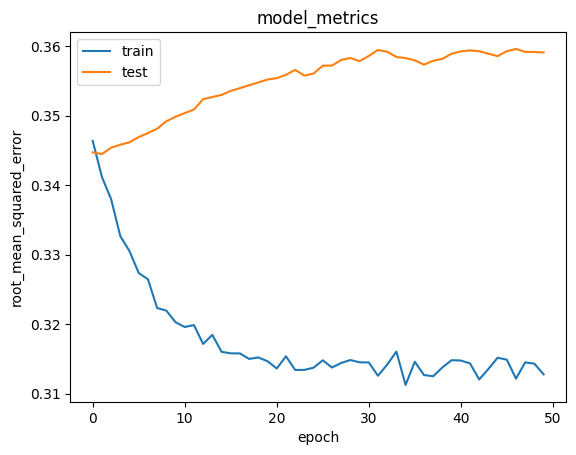

In [46]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Grafik dan kode yang ditampilkan menunjukkan performa model rekomendasi berdasarkan nilai Root Mean Squared Error (RMSE) selama proses pelatihan. Pada grafik tersebut, garis biru mewakili RMSE untuk data pelatihan (train), sedangkan garis oranye untuk data validasi (test). Terlihat bahwa RMSE pada data pelatihan terus menurun seiring bertambahnya epoch, yang menunjukkan bahwa model semakin baik dalam mempelajari pola dari data pelatihan. Namun, RMSE pada data validasi justru meningkat setelah beberapa epoch, yang menandakan terjadinya overfitting—model terlalu fokus pada data pelatihan sehingga kehilangan kemampuan untuk menggeneralisasi ke data baru.

In [47]:
# Mengambil sample user
user_id = df.userID.sample(1).iloc[0]
places_visited_by_user = df[df.userID == user_id]

# Tempat yang belum dikunjungi user
# Mengganti 'id' dengan 'placeID'
places_not_visited = fix_tourism[~fix_tourism['placeID'].isin(places_visited_by_user.placeID.values)]['placeID']
places_not_visited = list(
    set(places_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

places_not_visited = [[place_to_place_encoded.get(x)] for x in places_not_visited]
user_encoder = user_to_user_encoded.get(user_id)

user_place_array = np.hstack(
    ([[user_encoder]] * len(places_not_visited), places_not_visited)
)

Langkah ini dimulai dengan mengambil secara acak satu user dari data, lalu mengidentifikasi tempat-tempat wisata yang telah dikunjungi user tersebut. Selanjutnya, sistem mencari tempat-tempat yang belum dikunjungi user tersebut dari data `fix_tourism`, lalu mengonversinya ke dalam bentuk encoded sesuai dengan model. Data ini kemudian dikombinasikan dengan ID user yang telah diencoding untuk membentuk array input yang siap diprediksi oleh model rekomendasi.


In [48]:
# Mengambil sample user
user_id = df.userID.sample(1).iloc[0]
places_visited_by_user = df[df.userID == user_id]

# Tempat yang belum dikunjungi user
# Mengganti 'id' dengan 'placeID'
# Corrected column name from 'id' to 'placeID' in fix_tourism
places_not_visited = fix_tourism[~fix_tourism['placeID'].isin(places_visited_by_user.placeID.values)]['placeID']
places_not_visited = list(
    set(places_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

# Ubah jadi input model
places_not_visited = [[place_to_place_encoded.get(x)] for x in places_not_visited]
user_encoder = user_to_user_encoded.get(user_id)

user_place_array = np.hstack(
    ([[user_encoder]] * len(places_not_visited), places_not_visited)
)

# Prediksi rating dari model
ratings = model.predict(user_place_array).flatten()

# Ambil top 10 rekomendasi dengan skor tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(places_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for user:', user_id)
print('=' * 30)
print('Tempat wisata dengan rating tinggi dari user')
print('-' * 30)

top_places_user = (
    places_visited_by_user.sort_values(
        by='Place_Ratings',
        ascending=False
    )
    .head(5)
    .placeID.values
)

# Replaced tourism_df with tourism_new which contains 'id' column
tourism_new_rows = tourism_new[tourism_new['id'].isin(top_places_user)]
for row in tourism_new_rows.itertuples():
    print(row.place_name, ':', row.category)

print('-' * 30)
print('Top 10 rekomendasi tempat wisata')
print('-' * 30)

# Replaced tourism_df with tourism_new
recommended_places = tourism_new[tourism_new['id'].isin(recommended_place_ids)]
for row in recommended_places.itertuples():
    print(row.place_name, ':', row.category)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Showing recommendations for user: 20
Tempat wisata dengan rating tinggi dari user
------------------------------
Pantai Ngandong : Bahari
Alun-Alun Kota Bandung : Taman Hiburan
Masjid Pusdai : Tempat Ibadah
Taman Miniatur Kereta Api : Taman Hiburan
Kota Lama Semarang : Budaya
------------------------------
Top 10 rekomendasi tempat wisata
------------------------------
The World Landmarks - Merapi Park Yogyakarta : Taman Hiburan
Pantai Baron : Bahari
Dago Dreampark : Taman Hiburan
Stone Garden Citatah : Taman Hiburan
Bukit Moko : Cagar Alam
Kampung Korea Bandung : Budaya
Tafso Barn : Cagar Alam
Bukit Jamur : Cagar Alam
Kota Mini : Taman Hiburan
Desa Wisata Lembah Kalipancur : Taman Hiburan


Kode ini melakukan proses rekomendasi destinasi wisata untuk satu pengguna secara personalized menggunakan model prediksi rating. Pertama, dipilih secara acak satu user dari data interaksi pengguna, lalu diambil daftar tempat wisata yang sudah dikunjungi dan diberi rating oleh user tersebut. Selanjutnya, sistem menentukan tempat-tempat wisata yang belum dikunjungi oleh user dengan memfilter dari data lengkap destinasi (`fix_tourism` dan `tourism_new`). Tempat yang belum dikunjungi ini kemudian diubah ke format yang sesuai dengan input model rekomendasi, dengan meng-encode user dan tempat wisata ke dalam bentuk numerik. Model prediksi yang sudah dilatih kemudian digunakan untuk memperkirakan rating yang akan diberikan user terhadap setiap tempat yang belum dikunjungi. Dari hasil prediksi tersebut, diambil 10 tempat dengan skor rating tertinggi sebagai rekomendasi. Hasil output menampilkan dua bagian yaitu pertama, 5 tempat wisata yang pernah dikunjungi user dengan rating tinggi, yang menunjukkan preferensi user saat ini, dan kedua, 10 rekomendasi tempat wisata yang diprediksi cocok dan menarik bagi user berdasarkan model. Contohnya, user dengan ID 20 telah memberikan rating tinggi pada tempat wisata seperti “Pantai Ngandong” dan “Alun-Alun Kota Bandung,” dan model merekomendasikan destinasi seperti “The World Landmarks - Merapi Park Yogyakarta” dan “Pantai Baron” yang memiliki kategori mirip atau relevan dengan preferensi user tersebut. Dengan demikian, pendekatan ini memberikan rekomendasi yang personal dan relevan berdasarkan data rating historis dan prediksi model.
